In [ ]:
# ----------------------------------
#          Backtesting.py
# ----------------------------------

"""
Lightweight backtesting engine for stock-prediction pipeline.

_  CSV File that contain Date, Open, High, Low, Close, Volume (Close is used as execution price by default).
_  Predictions CSV Should Contain at least one row with columns:  Target, Prediction (if singlr prediction) OR
    a DataFrame with a column 'Pred_next_close' aligned to the same dates as your feature after appropriate merging.
-  Default signal: Go long 1 unit at next open if predicted_next_close > close (you can change the rule).

Author: Generated for your pipeline
"""
    

⚠️ Using default --data = reliance_features.csv
⚠️ Using default --preds = models/next_close/predictions_modelwide_next_close.csv
Backtest stats:
  total_return: 162.2415972089198
  cagr: 1.4972260402847022
  ann_vol: 10.458297184184945
  sharpe: 0.20165174349984571
  max_drawdown_pct: -1.2402314296833195
  days: 1403
Trades generated: 445


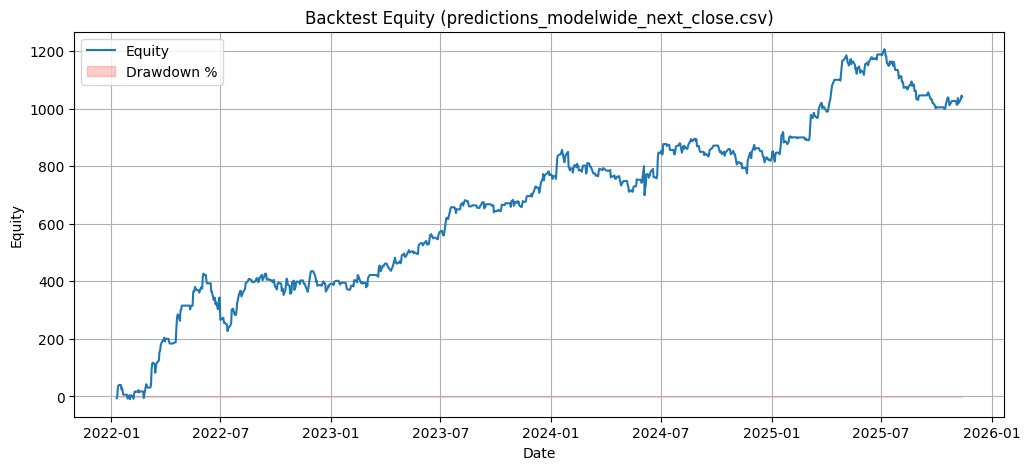

In [2]:
import argparse
import glob
import os
from typing import Optional, Tuple, Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -------------------------
# Utility metrics
# -------------------------
def calc_drawdown(equity: pd.Series) -> pd.DataFrame:
    equity = equity.ffill().fillna(0.0)
    peak = equity.cummax()
    drawdown = equity - peak
    drawdown_pct = drawdown / peak.replace(0, np.nan)
    return pd.DataFrame({
        "equity": equity,
        "peak": peak,
        "drawdown": drawdown,
        "drawdown_pct": drawdown_pct
    })


def max_drawdown_pct(equity: pd.Series) -> float:
    dd = calc_drawdown(equity)
    if dd["drawdown_pct"].isnull().all():
        return 0.0
    return float(dd["drawdown_pct"].min())


def annualize_return(total_return: float, days: int) -> float:
    if days <= 0:
        return 0.0
    return (1.0 + total_return) ** (252.0 / days) - 1.0


def annualized_vol(returns: pd.Series) -> float:
    if returns.empty:
        return 0.0
    return float(returns.std(ddof=0) * np.sqrt(252.0))


def sharpe_ratio(returns: pd.Series, rf: float = 0.0) -> float:
    if returns.empty:
        return 0.0
    ann_ret = returns.mean() * 252.0
    ann_vol = returns.std(ddof=0) * np.sqrt(252.0)
    if ann_vol == 0:
        return 0.0
    return float((ann_ret - rf) / ann_vol)


# -------------------------
# Prediction -> signals
# -------------------------
def generate_signals_from_predictions(
    features: pd.DataFrame,
    preds: pd.DataFrame,
    pred_col: str = "prediction",
    date_col: str = "Date",
) -> pd.DataFrame:
    """
    Merge predictions into features dataframe to create column 'pred_next_close'.
    If preds includes Date -> left-merge on Date.
    If preds is one-row (one-shot next-day), attach to last row.
    If preds has many rows but no Date, align last n preds to last n feature rows.
    """
    df = features.copy()
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).reset_index(drop=True)

    pred_df = preds.copy()
    if date_col in pred_df.columns:
        pred_df[date_col] = pd.to_datetime(pred_df[date_col])
        merged = pd.merge(df, pred_df[[date_col, pred_col]], on=date_col, how="left")
        merged = merged.rename(columns={pred_col: "pred_next_close"})
    else:
        if len(pred_df) == 1:
            # one-shot next-day prediction -> attach to last row
            pred_value = float(pred_df[pred_col].iloc[0])
            df = df.copy()
            df["pred_next_close"] = np.nan
            df.loc[df.index[-1], "pred_next_close"] = pred_value
            merged = df
        else:
            df = df.copy()
            df["pred_next_close"] = np.nan
            n = min(len(pred_df), len(df))
            df.loc[df.index[-n:], "pred_next_close"] = pred_df[pred_col].values[-n:]
            merged = df

    return merged


# -------------------------
# Signals -> trades
# -------------------------
def signals_to_trades(
    df: pd.DataFrame,
    signal_col: str = "signal",
    price_col: str = "Open",
    size: float = 1.0,
    commission_per_trade: float = 0.0,
    slippage_pct: float = 0.0,
    stop_loss_pct: Optional[float] = None,
    take_profit_pct: Optional[float] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Convert signals into trade log and daily equity series.

    Entry: 0 -> 1 transition; executed at Open*(1+slippage).
    Exit: intraday stop-loss / take-profit (checked against Low/High) OR when signal flips to 0 (exit at Open*(1-slippage)).
    """
    df = df.copy().reset_index(drop=True)
    if signal_col not in df.columns:
        df[signal_col] = 0
    df[signal_col] = df.get(signal_col, 0).fillna(0).astype(int)

    trades: List[dict] = []
    position = 0
    entry_price = None
    entry_index = None

    daily_positions: List[int] = []
    equity_list: List[float] = []
    cum_realized = 0.0

    for i in range(len(df)):
        sig = int(df.loc[i, signal_col])
        open_p = float(df.loc[i, "Open"]) if "Open" in df.columns else float(df.loc[i, "Close"])
        high_p = float(df.loc[i, "High"]) if "High" in df.columns else open_p
        low_p = float(df.loc[i, "Low"]) if "Low" in df.columns else open_p
        close_p = float(df.loc[i, "Close"]) if "Close" in df.columns else open_p

        prev_sig = int(df.loc[i - 1, signal_col]) if i > 0 else 0

        # ENTRY (0 -> 1)
        if prev_sig == 0 and sig == 1 and position == 0:
            executed_price = open_p * (1.0 + slippage_pct)
            entry_price = executed_price
            entry_index = i
            position = 1
            trades.append({
                "type": "entry",
                "index": i,
                "price": float(executed_price),
                "size": float(size),
                "commission": float(commission_per_trade),
                "slippage": float(slippage_pct)
            })

        # If position open, check stop/tp intrabar then signal-exit
        if position == 1 and entry_price is not None:
            stopped = False
            stop_price = None
            tp_price = None
            if stop_loss_pct is not None:
                stop_price = entry_price * (1.0 - stop_loss_pct)
            if take_profit_pct is not None:
                tp_price = entry_price * (1.0 + take_profit_pct)

            # Stop first
            if stop_price is not None and low_p <= stop_price:
                exit_price = max(low_p, stop_price) * (1.0 - slippage_pct)
                pnl = (exit_price - entry_price) * size - commission_per_trade
                trades.append({
                    "type": "exit_stop",
                    "index": i,
                    "price": float(exit_price),
                    "size": float(size),
                    "pnl": float(pnl),
                    "commission": float(commission_per_trade),
                    "slippage": float(slippage_pct)
                })
                cum_realized += pnl
                position = 0
                entry_price = None
                entry_index = None
                stopped = True

            # TP next
            if (not stopped) and (tp_price is not None) and (high_p >= tp_price):
                exit_price = min(high_p, tp_price) * (1.0 - slippage_pct)
                pnl = (exit_price - entry_price) * size - commission_per_trade
                trades.append({
                    "type": "exit_tp",
                    "index": i,
                    "price": float(exit_price),
                    "size": float(size),
                    "pnl": float(pnl),
                    "commission": float(commission_per_trade),
                    "slippage": float(slippage_pct)
                })
                cum_realized += pnl
                position = 0
                entry_price = None
                entry_index = None
                stopped = True

            # If neither stopped nor tp and signal flipped to 0 -> exit at open
            if (not stopped) and prev_sig == 1 and sig == 0 and position == 1:
                exit_price = open_p * (1.0 - slippage_pct)
                pnl = (exit_price - entry_price) * size - commission_per_trade
                trades.append({
                    "type": "exit_signal",
                    "index": i,
                    "price": float(exit_price),
                    "size": float(size),
                    "pnl": float(pnl),
                    "commission": float(commission_per_trade),
                    "slippage": float(slippage_pct)
                })
                cum_realized += pnl
                position = 0
                entry_price = None
                entry_index = None

        # daily MTM
        if position == 1 and entry_price is not None:
            unreal = (close_p - entry_price) * size
        else:
            unreal = 0.0
        equity_list.append(cum_realized + unreal)
        daily_positions.append(position)

    daily_df = df.copy()
    daily_df["position"] = daily_positions
    daily_df["equity"] = equity_list

    trades_df = pd.DataFrame(trades)
    return trades_df, daily_df


# -------------------------
# Performance summary
# -------------------------
def compute_performance_stats(daily_df: pd.DataFrame) -> Dict[str, Any]:
    equity = daily_df["equity"].ffill().fillna(0.0)
    if len(equity) < 2:
        return {
            "total_return": 0.0,
            "cagr": 0.0,
            "ann_vol": 0.0,
            "sharpe": 0.0,
            "max_drawdown_pct": 0.0,
            "days": int(len(daily_df))
        }

    start_eq = float(equity.iloc[0]) if len(equity) > 0 else 0.0
    end_eq = float(equity.iloc[-1])
    denom = max(1e-9, abs(start_eq) + 1e-9)
    total_return = (end_eq - start_eq) / denom

    try:
        start = pd.to_datetime(daily_df["Date"].iloc[0])
        end = pd.to_datetime(daily_df["Date"].iloc[-1])
        days = (end - start).days
    except Exception:
        days = len(daily_df)
    if days <= 0:
        days = max(1, len(daily_df))

    eq_shift = equity.shift(1).replace(0, np.nan)
    daily_ret = (equity - equity.shift(1)) / eq_shift
    daily_ret = daily_ret.fillna(0.0)

    ann_return = annualize_return(total_return, days)
    ann_vol = annualized_vol(daily_ret)
    sr = sharpe_ratio(daily_ret)
    mdd = max_drawdown_pct(equity)

    return {
        "total_return": float(total_return),
        "cagr": float(ann_return),
        "ann_vol": float(ann_vol),
        "sharpe": float(sr),
        "max_drawdown_pct": float(mdd),
        "days": int(days)
    }


# -------------------------
# Signals rule (default)
# -------------------------
def default_signal_rule(df: pd.DataFrame, threshold: float = 0.0) -> pd.DataFrame:
    df = df.copy()
    df["pred_next_close"] = pd.to_numeric(df.get("pred_next_close", np.nan), errors="coerce")
    # apply threshold: prediction must be greater than Close * (1 + threshold)
    df["signal"] = (df["pred_next_close"] > df["Close"] * (1.0 + float(threshold))).astype(int)
    return df


# -------------------------
# High-level runner
# -------------------------
def run_backtest_from_predictions(
    features_csv: str,
    preds_csv: str,
    out_report_csv: Optional[str] = None,
    price_col: str = "Open",
    signal_threshold: float = 0.0,
    size: float = 1.0,
    commission_per_trade: float = 0.0,
    slippage_pct: float = 0.0,
    stop_loss_pct: Optional[float] = None,
    take_profit_pct: Optional[float] = None,
) -> Dict[str, Any]:
    # load files
    feats = pd.read_csv(features_csv, parse_dates=["Date"] if "Date" in pd.read_csv(features_csv, nrows=0).columns else None)
    preds = pd.read_csv(preds_csv, parse_dates=["Date"] if "Date" in pd.read_csv(preds_csv, nrows=0).columns else None)

    # diagnostics: if preds has only 1 row, inform user
    if len(preds) == 1 and "Date" not in preds.columns:
        print("⚠️ Predictions file appears to be a single next-day value. Backtest will attach it only to the last row (no historical signals).")
    merged = generate_signals_from_predictions(feats, preds)
    merged = default_signal_rule(merged, threshold=signal_threshold)

    trades, daily = signals_to_trades(
        merged,
        signal_col="signal",
        price_col=price_col,
        size=size,
        commission_per_trade=commission_per_trade,
        slippage_pct=slippage_pct,
        stop_loss_pct=stop_loss_pct,
        take_profit_pct=take_profit_pct
    )

    stats = compute_performance_stats(daily)
    report = {"stats": stats, "trades": trades, "daily": daily}

    if out_report_csv:
        os.makedirs(os.path.dirname(out_report_csv) or ".", exist_ok=True)
        daily_report_cols = ["Date", "Close", "pred_next_close", "signal", "position", "equity"]
        existing_cols = [c for c in daily_report_cols if c in daily.columns]
        daily[existing_cols].to_csv(out_report_csv, index=False)

    return report


# -------------------------
# Plot helpers
# -------------------------
def plot_equity_and_drawdown(daily_df: pd.DataFrame, title: str = "Equity Curve"):
    plt.figure(figsize=(12, 5))
    if "Date" in daily_df.columns:
        x = daily_df["Date"]
    else:
        x = range(len(daily_df))
    plt.plot(x, daily_df["equity"], label="Equity")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.grid(True)

    dd = calc_drawdown(daily_df["equity"])
    draw_pct = dd["drawdown_pct"].fillna(0.0)
    plt.fill_between(x, draw_pct, 0, color="red", alpha=0.2, label="Drawdown %")
    plt.legend()
    plt.show()


# -------------------------
# CLI utilities
# -------------------------
def find_default_preds() -> Optional[str]:
    # prefer model-wide preds, then full walk-forward preds, else single next-day preds
    candidates = [
        "models/next_close/predictions_modelwide_next_close.csv",
        "models/next_close/full_preds_next_close.csv",
        "models/next_close/predictions_modelwide_next_close.csv",
        "prediction_next_close.csv"
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None


def auto_defaults_if_missing(parsed_args):
    if getattr(parsed_args, "data", None) is None:
        # prefer engineered features file if present
        if os.path.exists("reliance_features.csv"):
            parsed_args.data = "reliance_features.csv"
        else:
            parsed_args.data = "reliance.csv"
        print(f"⚠️ Using default --data = {parsed_args.data}")
    if getattr(parsed_args, "preds", None) is None:
        default_preds = find_default_preds()
        parsed_args.preds = default_preds or "prediction_next_close.csv"
        print(f"⚠️ Using default --preds = {parsed_args.preds}")
    return parsed_args


def _cli():
    parser = argparse.ArgumentParser(description="Backtest engine with stop-loss/take-profit (Notebook-friendly)")
    parser.add_argument("--data", type=str, required=False, default=None, help="Path to engineered features CSV (Date, Close, Open...)")
    parser.add_argument("--preds", type=str, required=False, default=None, help="Path to predictions CSV (one-per-date preferred)")
    parser.add_argument("--out", type=str, default=None, help="Path to save daily backtest report CSV (optional)")
    parser.add_argument("--price_col", type=str, default="Open", help="Execution price column (Open recommended for next-day entries)")
    parser.add_argument("--commission", type=float, default=0.0, help="Per-trade commission")
    parser.add_argument("--slippage", type=float, default=0.0, help="Per-trade slippage percent (0.01 == 1%)")
    parser.add_argument("--size", type=float, default=1.0, help="Position size in units")
    parser.add_argument("--stop_loss", type=float, default=None, help="Stop loss percent (e.g., 0.02 for 2%)")
    parser.add_argument("--take_profit", type=float, default=None, help="Take profit percent (e.g., 0.05 for 5%)")
    parser.add_argument("--signal_threshold", type=float, default=0.0, help="Buy only when pred > Close*(1+threshold) e.g., 0.002")
    args, unknown = parser.parse_known_args()
    args = auto_defaults_if_missing(args)

    report = run_backtest_from_predictions(
        features_csv=args.data,
        preds_csv=args.preds,
        out_report_csv=args.out,
        price_col=args.price_col,
        signal_threshold=args.signal_threshold,
        size=args.size,
        commission_per_trade=args.commission,
        slippage_pct=args.slippage,
        stop_loss_pct=args.stop_loss,
        take_profit_pct=args.take_profit
    )

    stats = report["stats"]
    trades = report["trades"]
    daily = report["daily"]

    print("Backtest stats:")
    for k, v in stats.items():
        print(f"  {k}: {v}")
    print(f"Trades generated: {len(trades) if (isinstance(trades, pd.DataFrame) and not trades.empty) else 0}")
    plot_equity_and_drawdown(daily, title=f"Backtest Equity ({os.path.basename(args.preds)})")


if __name__ == "__main__":
    _cli()
